In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import pickle as pkl
from collections import defaultdict

In [2]:
PATH_TO_DATA = ('./data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
site_dict = pkl.load(open('./data/site_dic.pkl', 'rb'))
site_dict_inv = defaultdict(str, [(v, k) for (k, v) in site_dict.items()])

In [4]:
train_df.sort_values(by='time1', inplace=True)

In [5]:
times = ['time%s' % i for i in np.arange(1, 11)]
sites = ['site%s' % i for i in np.arange(1, 11)]

In [6]:
alice_df = train_df[train_df['target'] == 1]
not_alice_df = train_df[train_df['target'] == 0]
alice_df.shape, not_alice_df.shape

((2297, 21), (251264, 21))

In [7]:
alice_df[times] = alice_df[times].fillna(0).apply(pd.to_datetime)
alice_df[sites] = alice_df[sites].fillna(0).astype('int')

not_alice_df[times] = not_alice_df[times].fillna(0).apply(pd.to_datetime)
not_alice_df[sites] = not_alice_df[sites].fillna(0).astype('int')

train_df[times] = train_df[times].fillna(0).apply(pd.to_datetime)
train_df[sites] = train_df[sites].fillna(0).astype('int')

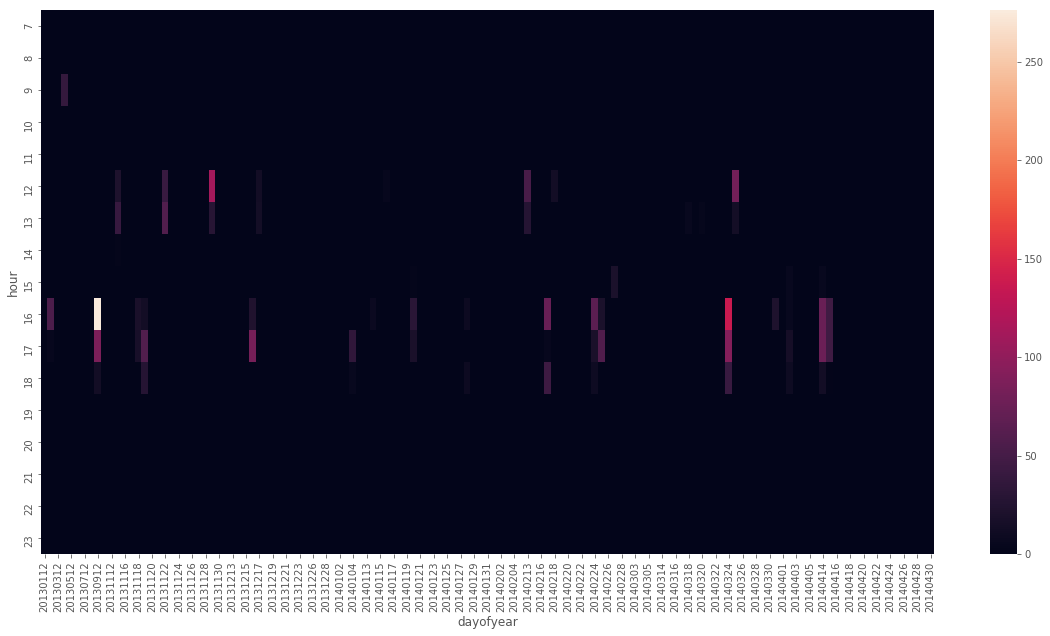

In [12]:
df = pd.concat([train_df.target,
                train_df.time1.apply(lambda x: x.year * 10000 + x.month * 100 + x.day).rename('dayofyear'),
                train_df.time1.dt.hour.rename('hour')], axis=1)
piv = pd.pivot_table(df, values="target",index=["hour"], columns=["dayofyear"], fill_value=0, aggfunc=np.sum)
plt.figure(figsize=(20, 10))
sns.heatmap(piv)

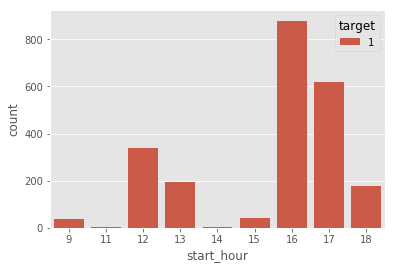

In [8]:
alice_df['start_hour'] = alice_df['time1'].apply(lambda x: x.hour)
not_alice_df['start_hour'] = not_alice_df['time1'].apply(lambda x: x.hour)
train_df['start_hour'] = train_df['time1'].apply(lambda x: x.hour)
sns.countplot(x='start_hour', data=alice_df, hue='target')

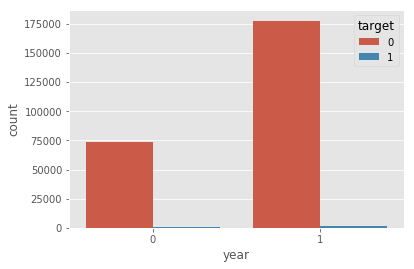

In [9]:
train_df['year'] = train_df['time1'].apply(lambda x: x.year - 2013)
sns.countplot(x='year', data=train_df, hue='target')

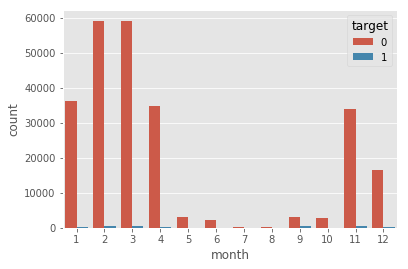

In [10]:
train_df['month'] = train_df['time1'].apply(lambda x: x.month)
sns.countplot(x='month', data=train_df, hue='target')

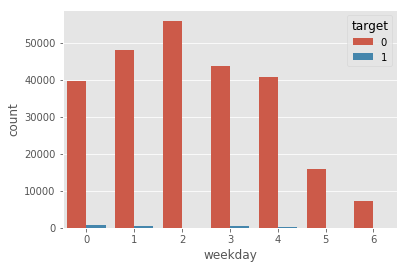

In [11]:
train_df['weekday'] = train_df['time1'].apply(lambda x: x.weekday())
sns.countplot(x='weekday', data=train_df, hue='target')

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa2e16b160>]],
      dtype=object)

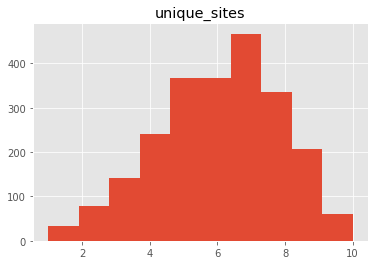

In [12]:
alice_df['unique_sites'] = [np.unique(row[row != 0]).shape[0] for row in 
                     tqdm_notebook(alice_df[['site%s' % i for i in np.arange(1, 11)]].values)]
alice_df.hist(column='unique_sites')

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa3777a048>]],
      dtype=object)

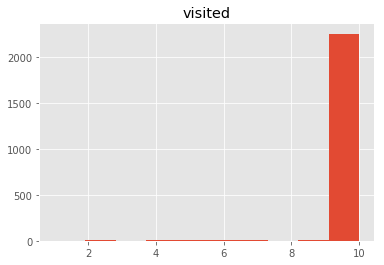

In [13]:
alice_df['visited'] = [row[row != 0].shape[0] for row in 
                     tqdm_notebook(alice_df[['site%s' % i for i in np.arange(1, 11)]].values)]
alice_df.hist(column='visited')

In [28]:
all_sites = defaultdict(int)
for row in tqdm_notebook(alice_df[sites].values):
    for site in row:
        all_sites[site] += 1

all_sites = sorted([(k, v) for (k, v) in all_sites.items()], key=lambda x: x[1], reverse=True)

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

In [34]:
top20sites = [i[0] for i in all_sites if i[1] > 10]
print(len(top20sites))

227


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26682df2b0>]],
      dtype=object)

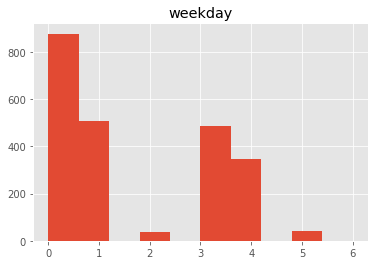

In [60]:
alice_df['weekday'] = alice_df['time1'].apply(lambda x: x.weekday())
alice_df.hist(column='weekday')

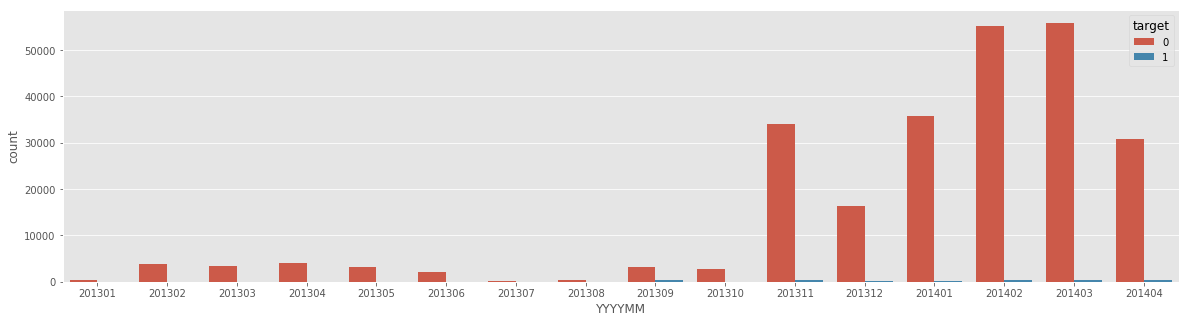

In [22]:
def get_yyyymm(time):
    year = time.year
    month = time.month
    if month < 10:
        return str(year) + '0' + str(month)
    else:
        return str(year) + str(month)

train_df['YYYYMM'] = train_df['time1'].apply(lambda x: get_yyyymm(x))
plt.figure(figsize=(20, 5))
sns.countplot(x='YYYYMM', data=train_df, hue='target')

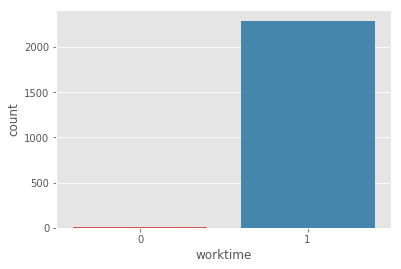

In [32]:
def is_worktime(hour, weekday):
    if weekday == 6:
        return 0
    if (hour >= 9 and hour <= 13) or (hour >= 15 and hour <= 18):
        return 1
    return 0
    
alice_df['worktime'] = alice_df['time1'].apply(lambda x: is_worktime(x.hour, x.weekday()))
sns.countplot(x='worktime', data=alice_df)

In [28]:
def get_duration(row):
    zero = np.datetime64('1970-01-01T00:00:00.000000000')
    cor = [r for r in row if r != zero]
    diff = (cor[-1] - cor[0])
    return diff
    
alice_df['duration'] = alice_df[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)
alice_df['visited'] = alice_df[sites].apply(lambda x: len(list(filter(lambda x: x != 0, x))), axis=1)
alice_df['sec_per_site'] = alice_df[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)

not_alice_df['duration'] = not_alice_df[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)
not_alice_df['visited'] = not_alice_df[sites].apply(lambda x: len(list(filter(lambda x: x != 0, x))), axis=1)
not_alice_df['sec_per_site'] = not_alice_df[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)

In [29]:
alice_df['sec_per_site'].describe(), not_alice_df['sec_per_site'].describe()

(count    2297.000000
 mean        5.630960
 std        19.005033
 min         0.000000
 25%         0.400000
 50%         1.100000
 75%         3.800000
 max       405.250000
 Name: sec_per_site, dtype: float64, count    251264.000000
 mean         16.803953
 std          45.149464
 min           0.000000
 25%           0.700000
 50%           2.800000
 75%          11.900000
 max         900.000000
 Name: sec_per_site, dtype: float64)

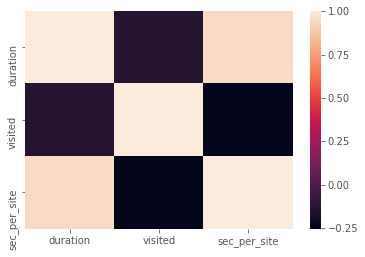

In [31]:
sns.heatmap(alice_df[['duration', 'visited', 'sec_per_site']].corr())

In [19]:
alice_df['time1'].apply(lambda x: x.month).value_counts()

2     471
11    446
3     400
9     377
4     340
12    134
1     129
Name: time1, dtype: int64

In [29]:
alice_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,target,start_hour,unique_sites
session_id,,,,,,,,,,,,,,,,,,,,,
251175,270,2013-02-12 16:25:10,270,2013-02-12 16:25:11,270,2013-02-12 16:32:10,21,2013-02-12 16:32:11,21,2013-02-12 16:32:24,...,2013-02-12 16:32:25,7832,2013-02-12 16:32:26,30,2013-02-12 16:32:27,7832,2013-02-12 16:32:27,1,16,4
196388,29,2013-02-12 16:32:27,7832,2013-02-12 16:32:28,37,2013-02-12 16:32:29,7832,2013-02-12 16:32:34,7832,2013-02-12 16:32:35,...,2013-02-12 16:32:42,29,2013-02-12 16:32:42,7832,2013-02-12 16:32:51,7832,2013-02-12 16:32:53,1,16,3
172448,29,2013-02-12 16:32:53,7832,2013-02-12 16:33:11,7832,2013-02-12 16:33:12,29,2013-02-12 16:33:13,37,2013-02-12 16:33:15,...,2013-02-12 16:33:24,7832,2013-02-12 16:33:33,29,2013-02-12 16:33:34,270,2013-02-12 16:33:46,1,16,4
70129,167,2013-02-12 16:33:50,167,2013-02-12 16:33:51,1515,2013-02-12 16:33:52,167,2013-02-12 16:33:52,37,2013-02-12 16:33:52,...,2013-02-12 16:33:52,1515,2013-02-12 16:33:53,855,2013-02-12 16:33:53,1514,2013-02-12 16:33:53,1,16,5
206254,1520,2013-02-12 16:33:55,1522,2013-02-12 16:33:56,1522,2013-02-12 16:34:01,1515,2013-02-12 16:34:12,1515,2013-02-12 16:34:13,...,2013-02-12 16:34:24,1515,2013-02-12 16:34:24,1520,2013-02-12 16:34:25,1521,2013-02-12 16:34:25,1,16,6
